# Reading MeteoSwiss Metranet data with Py-ART #

In this example, we will show how to read some of the MeteoSwiss Metranet products using Py-ART

Metranet is a binary format developped by the company ELDES and it is used for all MeteoSwiss radar products (Cartesian and Polar), however the format varies depending on the file type. The radar moments are stored in digital numbers (DN), using either one or two bytes. A conversion is then required to transform DN to physical units (dBZ or others).

 ## Reading Polar data ##

 ### Low-res data (MLx files) ###

We will start by reading a polar radar file from Lema at the standard 500 m resolution. The file correspond to sweep number 10 (elevation = 7.5°).

In [1]:
import pyart

data_dir = '/scratch/wolfensb/pyrad_courses/mch_jan_2024/data/'
file = data_dir + 'MLL2217907250U.010'

radar = pyart.aux_io.read_metranet(file)

/store/msrad/utils/anaconda3-wolfensb/envs/rainforest_tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



The output of the *read_metranet* command is a Py-ART radar object, that contains all available radar fields. The names are remapped to the Py-ART standard names. The conversion can be found [in this table](https://meteoswiss.github.io/pyrad/overview/list_variables.html#metranet-swiss-radars-to-pyrad)


| fieldname MCH | fieldname Py-ART                    |
|---------------|-------------------------------------|
| ZH            | reflectivity                        |
| ZV            | reflectivity_vv                     |
| ZDR           | differential_reflectivity           |
| RHO           | uncorrected_cross_correlation_ratio |
| PHI           | uncorrected_differential_phase      |
| VEL           | velocity                            |
| WID           | spectrum_width                      |
| CLT           | clutter_exit_code                   |
| ST1           | stat_test_lag1                      |
| ST2           | stat_test_lag2                      |
| WBN           | wide_band_noise                     |
| MPH           | mean_phase                          |

The [*read_metranet*](https://meteoswiss.github.io/pyart/API/generated/generated/pyart.aux_io.read_metranet.html) command is a high-level command that always reads fields in physical values. It cannot be used to read digital numbers (DN). 

The fields in the Py-ART object are masked arrays, and for reflectivity Py-ART masks both gates with DN = 0 (clutter-filtered) and DN = 1 (dry). 

It is however possible to separate dry from clutter-filtered pixels by reading the data "below" the mask. In Py-ART, clutter-filtered pixels have values of NaN and dry pixels have values of -31.5 dBZ. In the following we show how we can discriminate them by using the .data attribute of the numpy masked array

Text(0.5, 1.0, 'Clutter-filtered gates')

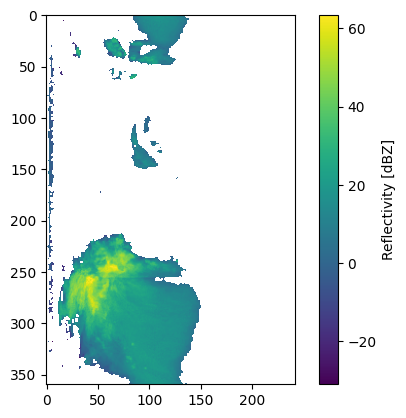

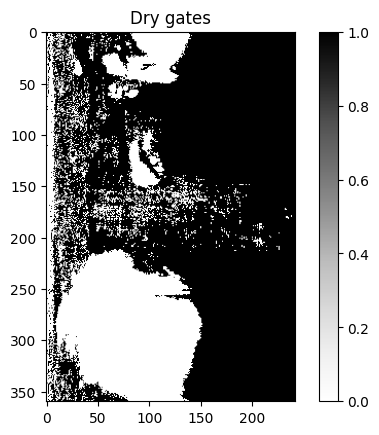

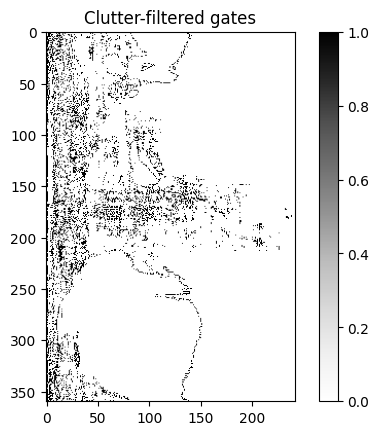

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.imshow(radar.get_field(0, 'reflectivity')); plt.colorbar(label = 'Reflectivity [dBZ]')
plt.figure()
plt.imshow(radar.get_field(0, 'reflectivity').data == -31.5, cmap=plt.cm.Grays); plt.colorbar()
plt.title('Dry gates')
plt.figure()
plt.imshow(np.isnan(radar.get_field(0, 'reflectivity').data), cmap=plt.cm.Grays); plt.colorbar()
plt.title('Clutter-filtered gates')

It is also possible to use a low-level command to read the metranet polar files. This command is called [*read_file_c*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_c.html) or [*read_file_py*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_py.html). The first is a version that relies on the C binaries (so files) from [Marco Boscacci's library](https://service.meteoswiss.ch/git/wod/py-radlib/), the second is a python only version, that will work anywhere, but is more prone to crashes than the C-version.

This command reads a single-moment at a time, either in DN or in physical units.

In [3]:
zh_DN = pyart.aux_io.read_file_c(file, moment = 'ZH')
print(zh_DN.data)

zh = pyart.aux_io.read_file_c(file, moment = 'ZH', physic_value=True)
print(zh.data)


[[0 0 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 0 2 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[  nan   nan -31.5 ... -31.5 -31.5 -31.5]
 [  nan   nan   nan ... -31.5 -31.5 -31.5]
 [  nan -31.5   nan ... -31.5 -31.5 -31.5]
 ...
 [  nan   nan -31.  ... -31.5 -31.5 -31.5]
 [  nan   nan -31.5 ... -31.5 -31.5 -31.5]
 [  nan   nan   nan ... -31.5 -31.5 -31.5]]


Here again, in DN, clutter = 0, dry = 1. In physical units, clutter = nan, dry = -31.5

### High-res data (MHx files) ###

High-resolution polar data (MHA, MHD, MHL, MHP, MHW files) can be read in the same fashion.

In [4]:
file_HR = data_dir + 'MHL2217907250U.010'

radar = pyart.aux_io.read_metranet(file_HR)


<font color='red'> However, the meaning of DN 0 and 1 is different for high-resolution files. DN = 0 corresponds to NaN in physical values and corresponds to dry pixels. DN = 1 corresponds to reflectivity = -31 dBZ (no special meaning). </font>

Text(0.5, 1.0, 'Dry gates')

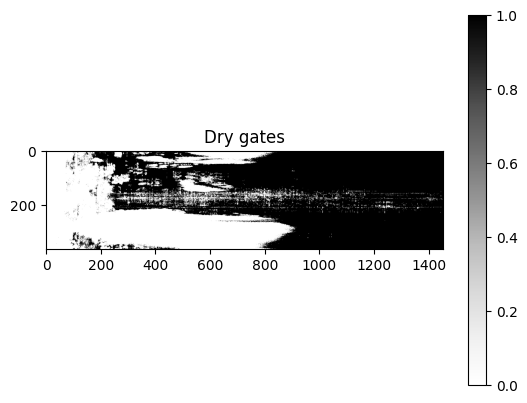

In [5]:
plt.figure()
plt.imshow(np.isnan(radar.get_field(0, 'reflectivity').data), cmap=plt.cm.Grays); plt.colorbar()
plt.title('Dry gates')

### Reading other polar products ###

Other derived polar products include hydrometeor classification files (YMx) and dealiased velocity files (DVx). They must be read with the *read_file_c* or *read_file_py* functions.

In [6]:
hydro = pyart.aux_io.read_file_c(data_dir + 'YML2217907257L.810', physic_value=False)
dealV = pyart.aux_io.read_file_c(data_dir + 'DVL2217907257L.810', physic_value=True)
print(hydro.data)
print(dealV.data)


py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0 75 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


The hydrometeor classification of MeteoSwiss has values of 25, 50, ..., 200 and does not correspond to the Py-ART mapping, which goes up to 9.
Pyrad provides a mapping function [map_hydro](https://meteoswiss.github.io/pyrad/API/generated/pyrad.io.map_hydro.html).

Welcome to PyDDA 1.3.1
Detecting Jax...
Jax is not installed on your system, unable to use Jax engine.
Detecting TensorFlow...
Unable to load both TensorFlow and tensorflow-probability. TensorFlow engine disabled.
No module named 'tensorflow'


/users/wolfensb/pyrad/src/pyrad_proc/pyrad/flow/flow_aux.py:52: UserWarning: Memory profiler not available
  warn('Memory profiler not available')
/store/msrad/utils/anaconda3-wolfensb/envs/rainforest_tests/lib/python3.10/site-packages/bokeh/core/property/primitive.py:37: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  bokeh_bool_types += (np.bool8,)


[Text(1, 0, 'NC'),
 Text(1, 1, 'AG'),
 Text(1, 2, 'CR'),
 Text(1, 3, 'LR'),
 Text(1, 4, 'RP'),
 Text(1, 5, 'RN'),
 Text(1, 6, 'VI'),
 Text(1, 7, 'WS'),
 Text(1, 8, 'MH'),
 Text(1, 9, 'IH/HDG')]

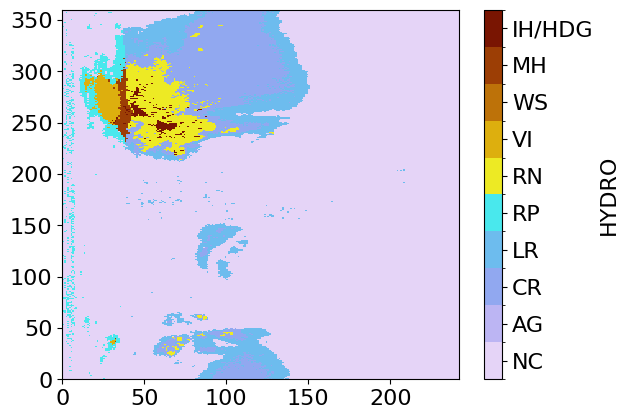

In [7]:
from pyrad.io.io_aux import map_hydro
import matplotlib as mpl
%matplotlib inline

hydro_remapped = map_hydro(hydro.data)

labels = ['NC','AG', 'CR', 'LR', 'RP', 'RN', 'VI', 'WS', 'MH', 'IH/HDG']
ticks = np.arange(len(labels))
boundaries = np.arange(-0.5, len(labels) )
norm = mpl.colors.BoundaryNorm(boundaries, 256)

plt.figure()
plt.pcolormesh(hydro_remapped, norm = norm, cmap = 'pyart_LangRainbow12')
cmap = plt.colorbar(label='HYDRO', ticks = ticks)
cmap.ax.set_yticklabels(labels)


## Reading Cartesian products ##

Cartesian products in Metranet format at MeteoSwiss include for example QPE files (RZC), POH files (BZC) as well as MESHS files (MZC). They can be read with the [*read_cartesian_metranet*](https://meteoswiss.github.io/pyart/API/generated/generated/pyart.aux_io.read_cartesian_metranet.html) function, which outputs a Py-ART grid object.

py_decoder DBG verb=0
py_decoder DBG verbl=0


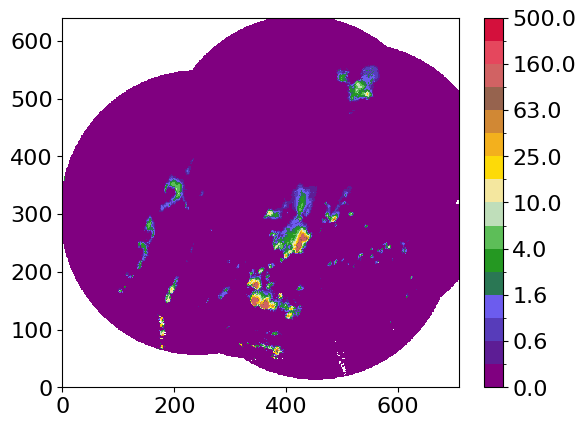

In [8]:
grid = pyart.aux_io.read_cartesian_metranet(data_dir + 'RZC221790725VL.801')

ticks = [0., 0.4, 0.63, 1., 1.6, 2.5, 4.0, 6.3, 10., 16., 25.,
                  40., 63., 100., 160., 250.]
boundaries =  [0., 0.4, 0.63, 1., 1.6, 2.5, 4.0, 6.3, 10., 16., 25.,
                       40., 63., 100., 160., 250., 500.]
norm = mpl.colors.BoundaryNorm(boundaries, 256)

plt.figure()
plt.pcolormesh(grid.fields['radar_estimated_rain_rate']['data'][0], norm=norm, cmap = 'pyart_RRate11'); plt.colorbar()


Here again low-level commands to read these Cartesian files are *read_file_c*  or *read_file_py*.

<font color='red'>  *read_file* is actually a wrapper that will call the function [*read_product*](https://github.com/MeteoSwiss/pyart/blob/master/pyart/aux_io/metranet_c.py#L819) if the file contains Cartesian data or [*read_polar*](https://github.com/MeteoSwiss/pyart/blob/master/pyart/aux_io/metranet_c.py#L554) if the file contains polar data.</font> 

In [9]:
qpe_data_DN = pyart.aux_io.read_file_c(data_dir + 'RZC221790725VL.801')
print(qpe_data_DN.data)

qpe_data = pyart.aux_io.read_file_c(data_dir + 'RZC221790725VL.801', physic_value=True)
print(qpe_data.data)


py_decoder DBG verb=0
py_decoder DBG verbl=0
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
py_decoder DBG verb=0
py_decoder DBG verbl=0
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


The following table summarizes all use cases

|            | Polar radar moments (MHx and MLx)                                                                                                                                                                      | Derived polar products (DVx, YMx)                                                                                                                                                                                    | Cartesian products (RZC, BZC, EZC, etc)                                                                                                                                                                              |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| High-level | [*read_metranet*](https://meteoswiss.github.io/pyart/API/generated/generated/pyart.aux_io.read_metranet.html)                                                                                          | None                                                                                                                                                                                                                 | [*read_cartesian_metranet*](https://meteoswiss.github.io/pyart/API/generated/generated/pyart.aux_io.read_cartesian_metranet.html)                                                                                    |
| Low-level  | [*read_file_py*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_py.html) or   [*read_file_c*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_c.html) |[*read_file_py*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_py.html) or   [*read_file_c*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_c.html) | [*read_file_py*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_py.html) or   [*read_file_c*](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_file_c.html) |

High-level implies that all content is read and the output is a Py-ART object (Radar or Grid) and low-level implies that only a single variable is read and the output is an object unrelated to Py-ART (and unusable by any Py-ART routine).